# Compression of VGG19 Model
## Varun Nawathey
### June 4, 2024

In [1]:
import torch
from torchvision import models, datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import ctypes
import copy

import zfpy

from scripts.zfp_compress import zfp_compress

lib = ctypes.CDLL('./speed_cluster.so')
lib.speed_cluster.argtypes = (ctypes.c_uint64, ctypes.c_uint64, ctypes.c_int)
lib.speed_cluster.restype = None

lib.speed_cluster_multithread.argtypes = (ctypes.c_uint64, ctypes.c_uint64, ctypes.c_int)
lib.speed_cluster.multithreadrestype = None

lib.speed_cluster_idx_already_clustered.argtypes = (ctypes.c_uint64, ctypes.c_uint64, ctypes.c_int, ctypes.c_uint64)
lib.speed_cluster_idx_already_clustered.restype = None

lib.speed_cluster_idx.argtypes = (ctypes.c_uint64, ctypes.c_uint64, ctypes.c_int, ctypes.c_uint64)
lib.speed_cluster_idx.restype = None

lib.unpack_indices.argtypes = (ctypes.c_uint64, ctypes.c_uint64, ctypes.c_int, ctypes.c_uint64)
lib.unpack_indices.restype = None

In [2]:
model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

preprocess = models.VGG19_Weights.IMAGENET1K_V1.transforms()

model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Weights are normally distributed

W ~ Normal(mu, sigma)  
W' = (W - mu) / sigma  
W' ~ Normal(0, 1)

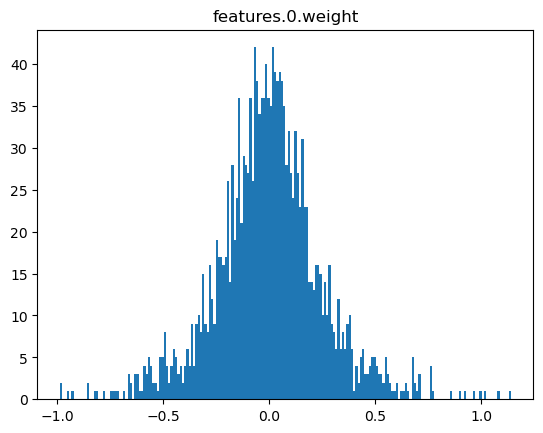

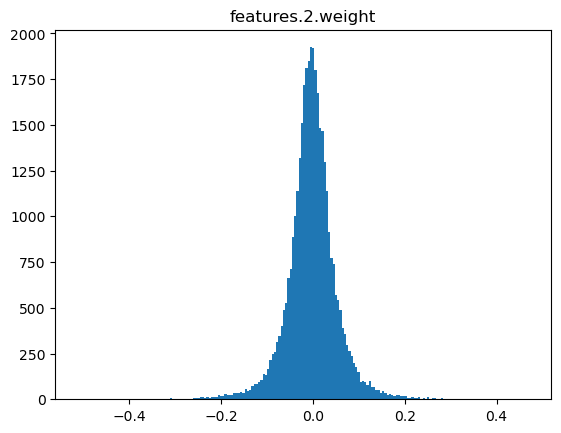

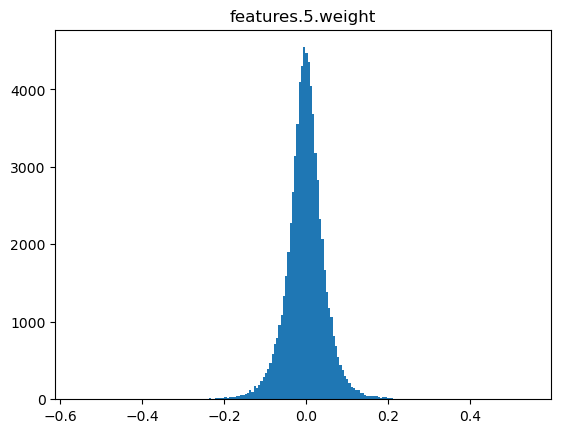

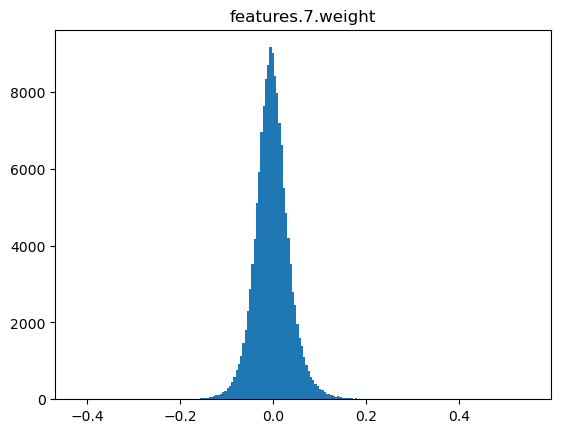

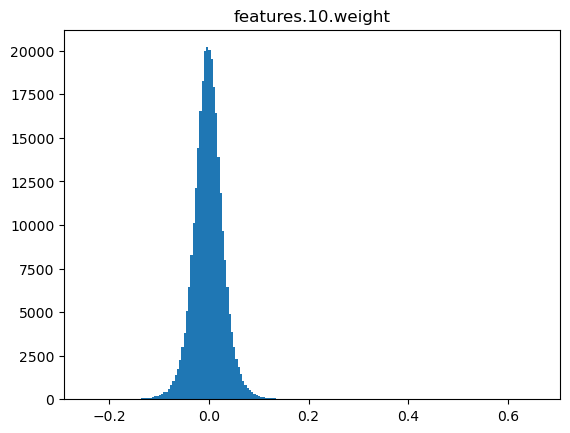

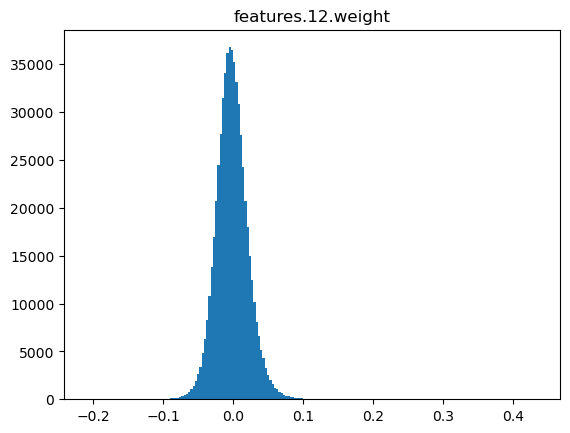

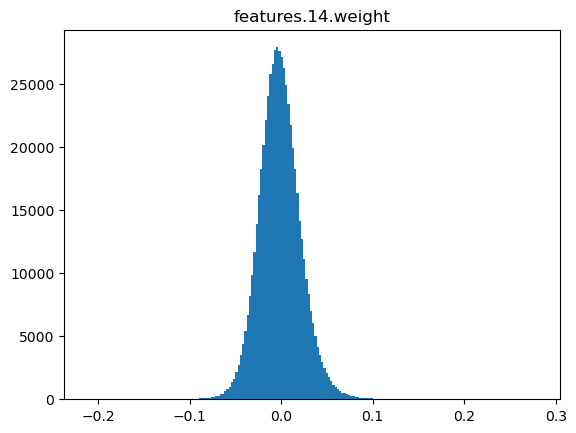

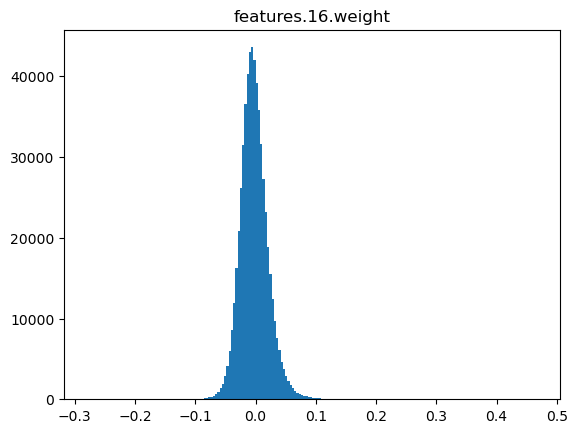

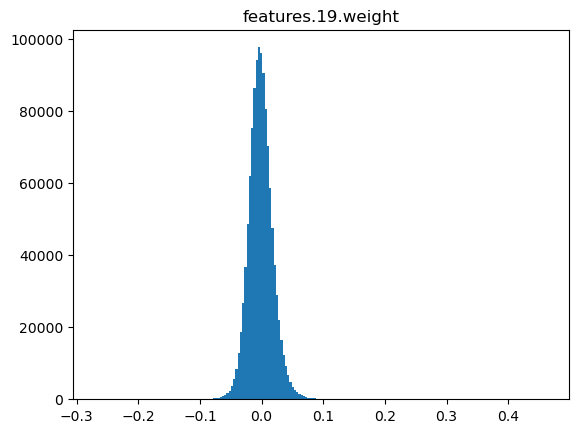

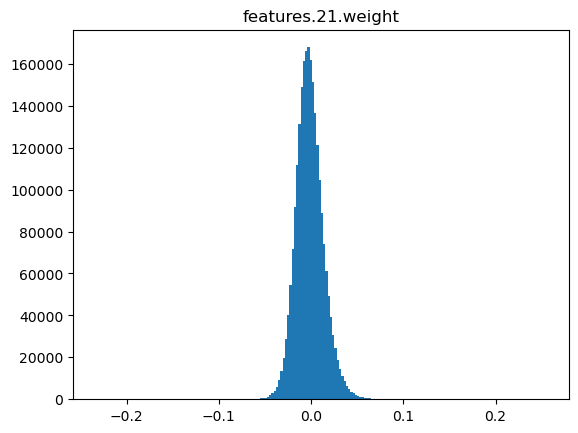

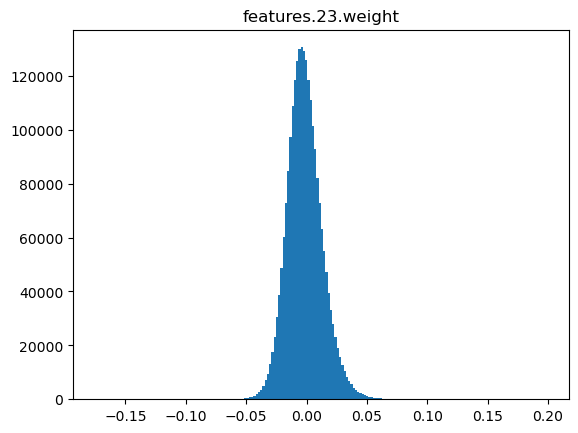

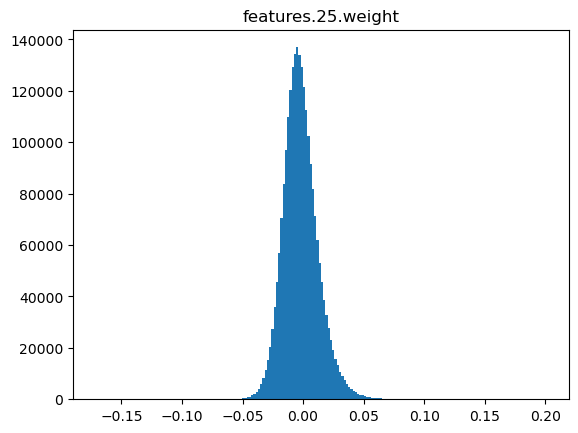

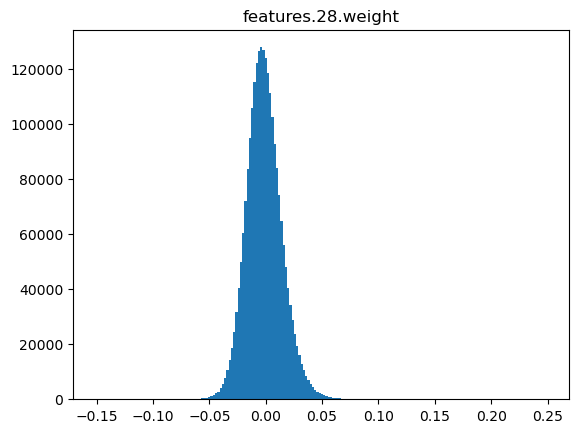

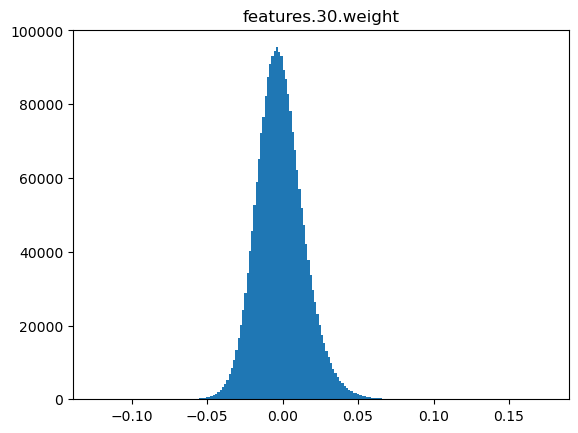

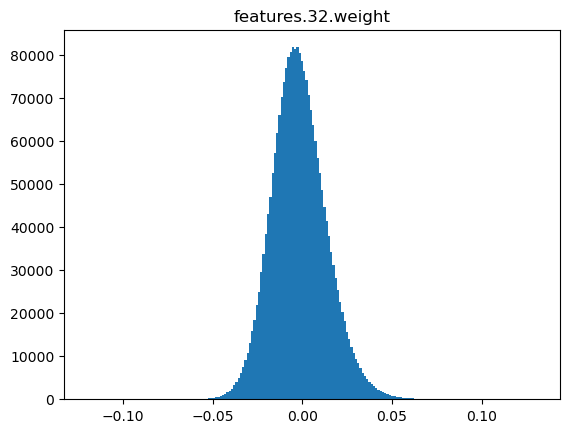

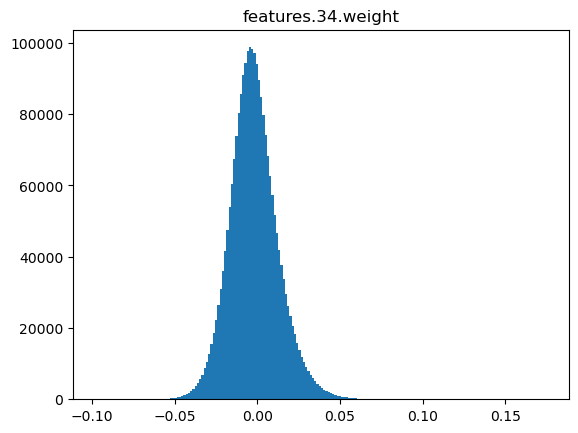

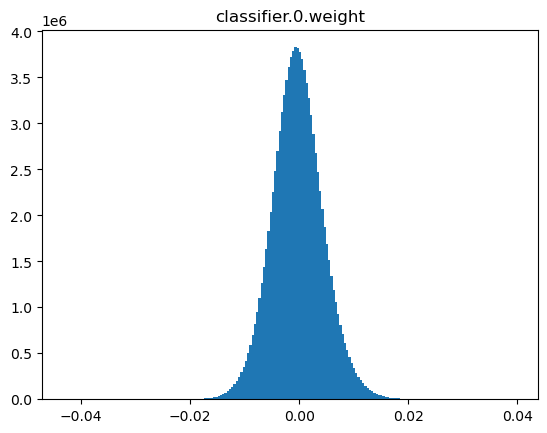

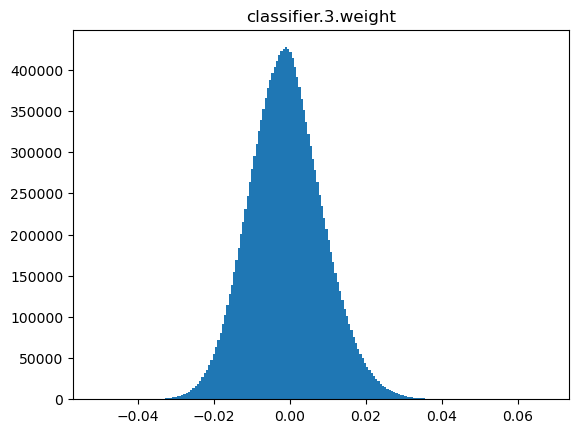

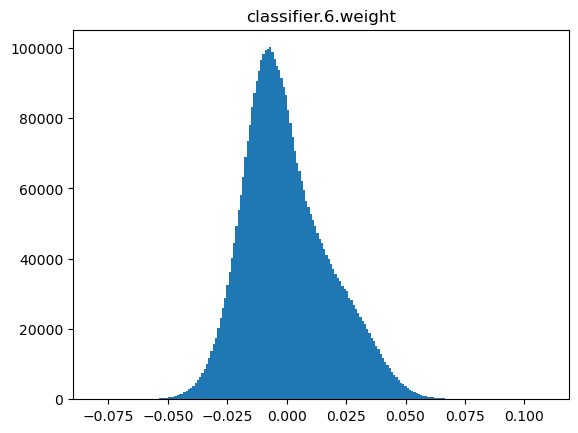

In [3]:
with torch.no_grad():
    for name, param in model.named_parameters():
        if 'weight' in name:
            # print('number of zeros:', param[param == 0].shape)
            plt.figure()
            plt.title(name)
            plt.hist(param.view(-1).numpy(), bins=200)

In [4]:
val_dataset = datasets.ImageNet(root='../EMLC_plus_LA_and_compression/', split='val', transform=preprocess)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [5]:
def calculate_accuracy(model, data_loader, num_batches=3):
    correct = 0
    total = 0

    with torch.no_grad():
        batches = 0
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            batches += 1
            if batches >= num_batches:
                break

    accuracy = correct / total
    return accuracy

# pretrained compressed size of VGG19 - zfp

In [6]:
zfp_model, org_size, compressed_size = zfp_compress(model, name="generic_model_type", tolerance=1e-3)

Original Size: 574682466
Compressed Size: 172284776


# pretrained accuracy of VGG19 on imagenet validation subset

In [7]:
accuracy = calculate_accuracy(model, val_loader, num_batches=4)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy: 85.16%


# various model compression strategies

1. Unstructured Pruning
2. Quantization from FP32 to Bfloat16 or FP16

3. cluster FP32 values to 16 centers with 4 bits per value. Also, because of the distribution of floating point values, there is still room for entropy coding to be done on the 4 bit nibbles. This can be done with pruning as well. I chose to do this after threshold pruning with a hand picked threshold.

In [8]:
# NF4 = torch.tensor([0.0, -1.0, -0.6961928009986877, -0.5250730514526367, -0.39491748809814453, -0.28444138169288635, -0.18477343022823334, -0.09105003625154495, 0.07958029955625534, 0.16093020141124725,
# 0.24611230194568634, 0.33791524171829224, 0.44070982933044434, 0.5626170039176941, 0.7229568362236023, 1.0], dtype=torch.float32)


clusters = torch.tensor([0.0,
                         0.2, 0.15, 0.1, 0.05, 0.02, 0.01, 0.005
                         -0.2, -0.15, -0.1, -0.05, -0.02, -0.01, -0.05
                        ], dtype=torch.float32)

with torch.no_grad():
    for name, param in model.named_parameters():
        if 'weight' in name and name != 'classifier.6.weight' and name != 'features.0.weight':
            # print(name, param.shape)

            # to standard normal
            # mu = param.mean()
            # sigma = param.std()
            
            # param.sub_(mu).div_(sigma)

            # plt.figure()
            # plt.title(name)
            # plt.hist(param.view(-1)[:10000], bins=20)

            # threshold pruning
            param[param.abs() < 0.005] = 0
            
            # cluster
            lib.speed_cluster_multithread(param.data_ptr(), clusters.data_ptr(), param.numel())

            # back to standard normal
            # param.mul_(sigma).add_(mu)

# convert to FP16
# model.half()

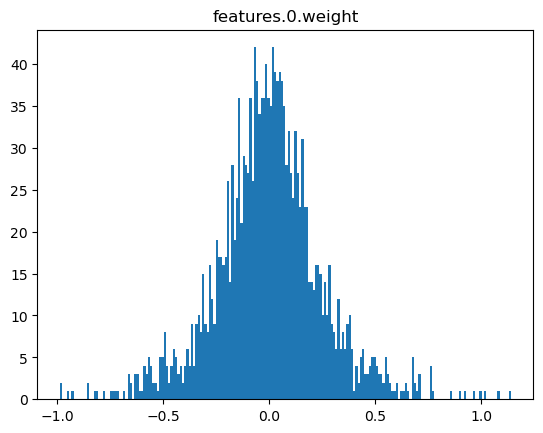

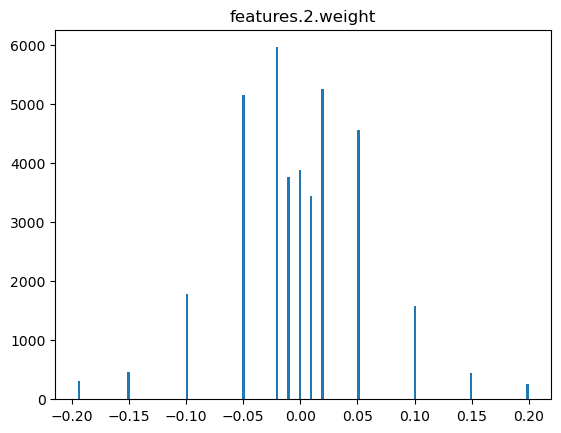

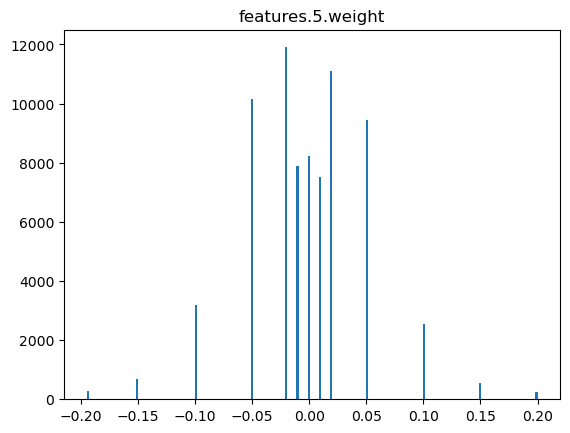

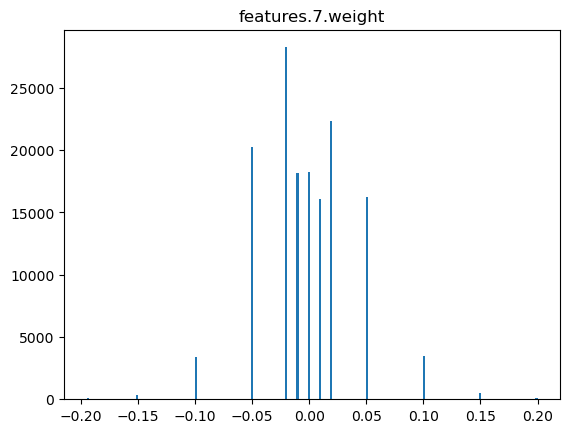

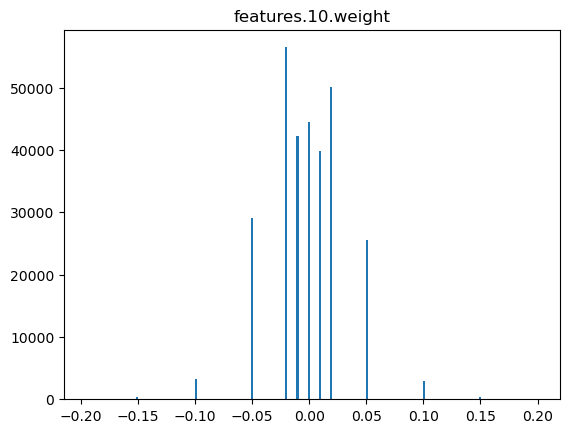

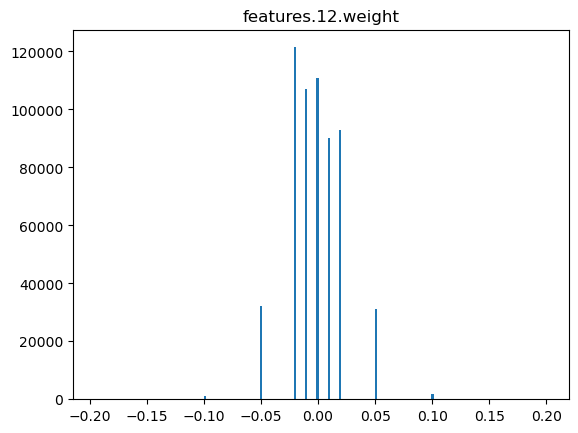

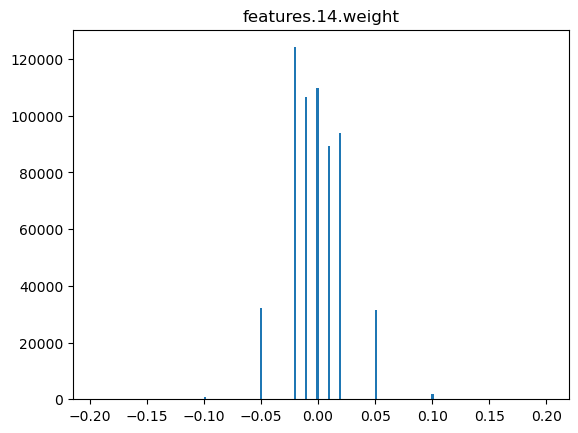

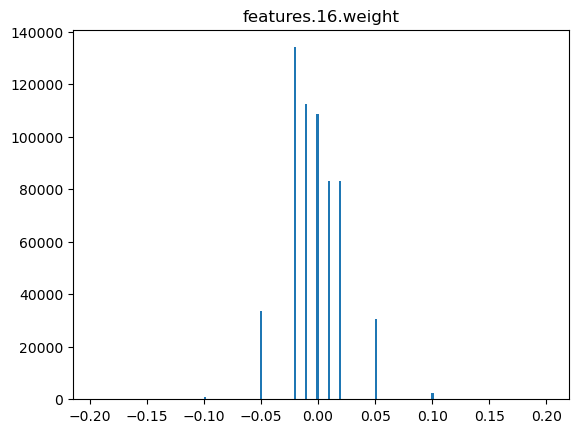

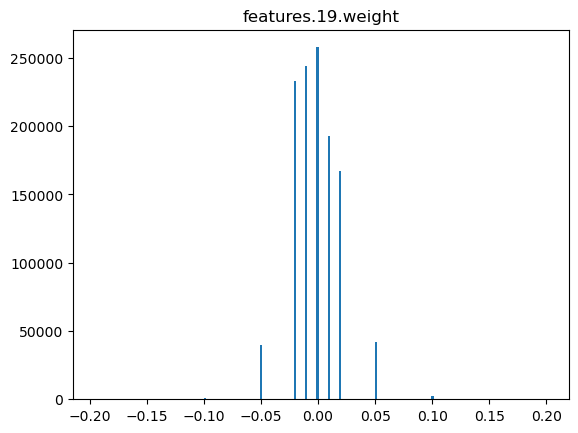

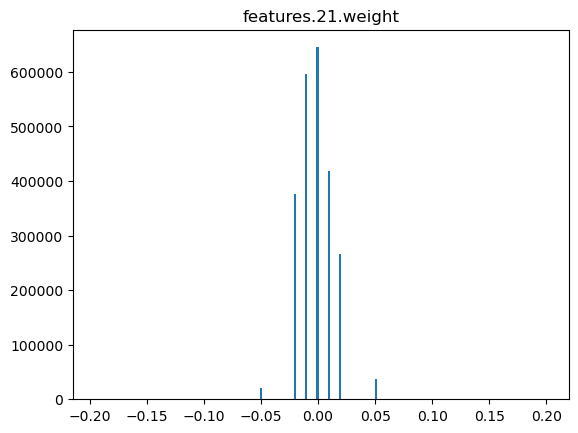

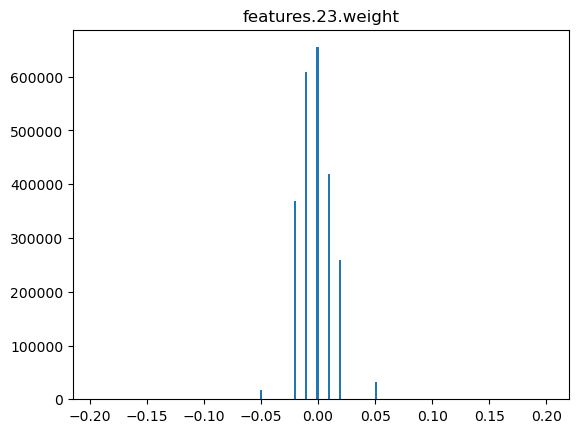

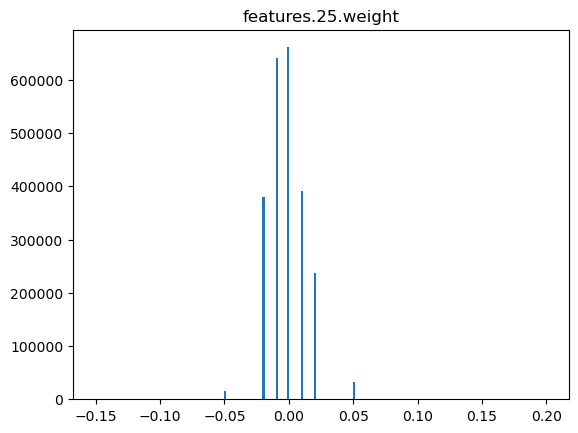

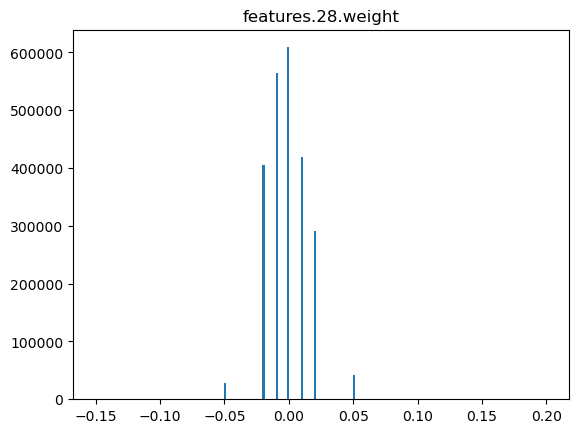

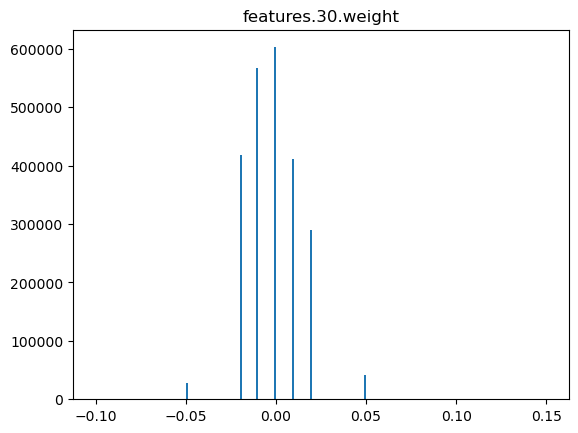

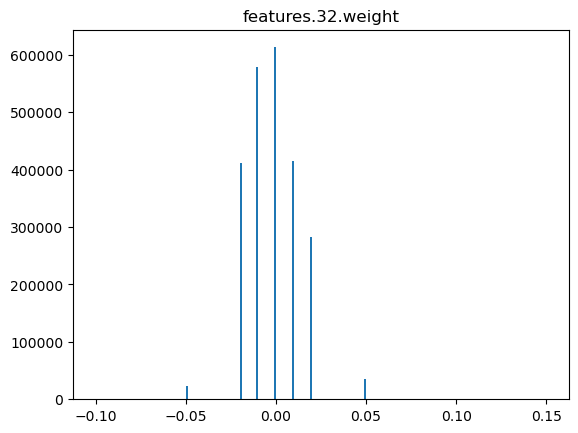

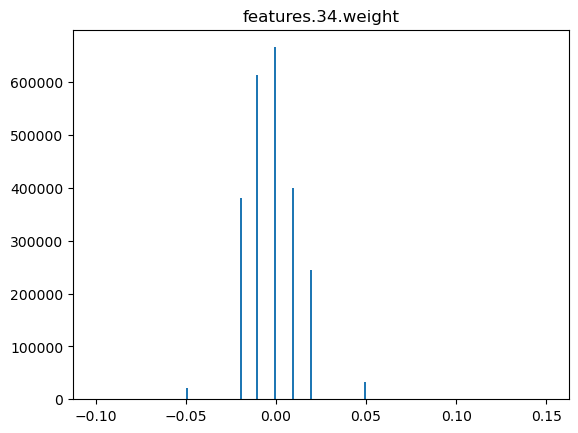

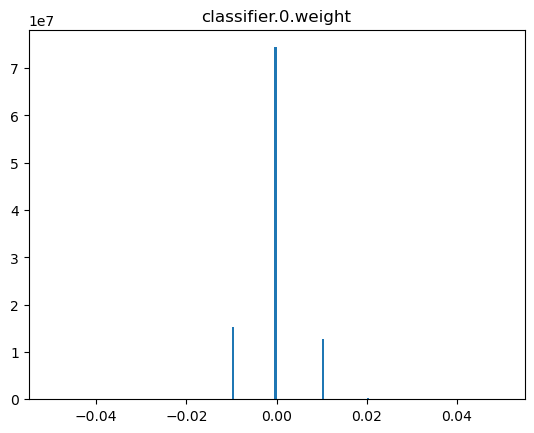

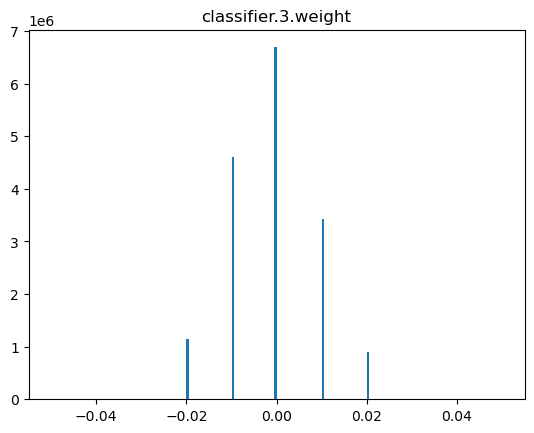

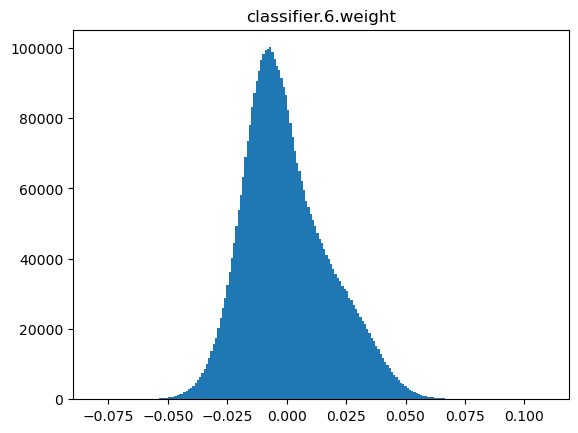

In [9]:
with torch.no_grad():
    for name, param in model.named_parameters():
        if 'weight' in name:
            plt.figure()
            plt.title(name)
            plt.hist(param.view(-1).numpy(), bins=200)

# compressed size of VGG19 after model compression strategies - zfp

In [10]:
zfp_model, org_size, compressed_size = zfp_compress(model, name="generic_model_type", tolerance=1e-3)

Original Size: 574682466
Compressed Size: 171102296


In [11]:
with torch.no_grad():
    size = 0
    for name, param in model.named_parameters():
        if 'weight' in name and name != 'classifier.6.weight' and name != 'features.0.weight':
            n = param.numel() // 2
            packed_idx = torch.empty(n + (4 -(n%4))%4, dtype=torch.torch.uint8)
            
            lib.speed_cluster_idx_already_clustered(param.data_ptr(), clusters.data_ptr(), param.numel(), packed_idx.data_ptr())
            
            packed_idx = packed_idx.view(torch.float32)
            compressed_param = zfpy.compress_numpy(packed_idx.numpy(), tolerance=1e-3)
            size += len(compressed_param)
        else:
            compressed_param = zfpy.compress_numpy(param.numpy(), tolerance=1e-3)
            size += len(compressed_param)
    print('zfp compressed size after compression methods with packed indices: ~', size, 'bytes')

zfp compressed size after compression methods with packed indices: ~ 54033400 bytes


# accuracy of VGG19 after model compression strategies

In [12]:
accuracy = calculate_accuracy(model, val_loader, num_batches=4)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy: 84.38%
